In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
from PIL import Image
import pickle
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, RepeatVector, Dot, Lambda
from tensorflow.keras.applications import DenseNet201, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
from textwrap import wrap

plt.rcParams['font.size'] = 14
sns.set_style('dark')
warnings.filterwarnings('ignore')

2024-05-28 05:12:45.668759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 05:12:45.668878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 05:12:45.779641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = "/kaggle/input/flickr8k/Images"

In [3]:
captionss = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
captionss.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [4]:
captionss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [5]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255
    
    return img

def displayImages(temp_df, nn):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(nn):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        # /kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg
        image = readImage(f"/kaggle/input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [6]:
img_data = np.random.random(size=(100, 100, 3))
img = array_to_img(img_data)
array = img_to_array(img)

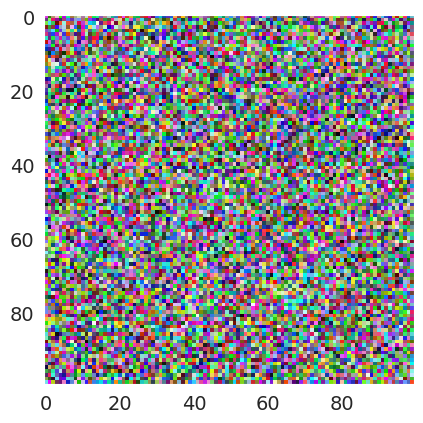

In [7]:
plt.imshow(img)

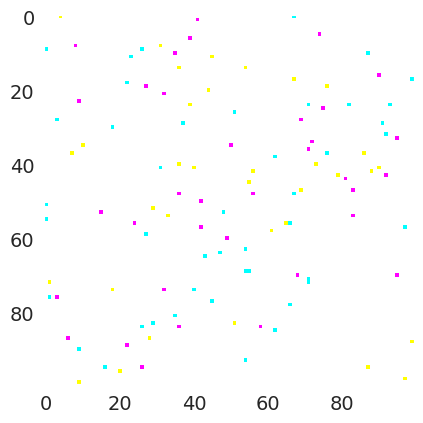

In [8]:
plt.imshow(array)

## Visualisation
- Images and their corresponding captions

In [9]:
displayImages(captionss.sample(20), 20)

## Caption Text Preprocessing Steps
- Convert sentences into lowercase
- Remove special characters, numbers and extra spaces present in the text
- Remove single characters
- Add a starting and an ending tag to sentences to indicate the beginning and ending of a sentence

In [ ]:
def textPreprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

## Preprocessed Text

In [11]:
data = textPreprocessing(captionss)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Encoded Representation
- The words in a sentence are tokenized and encoded into a one-hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

In [13]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

# Image Feature Extraction
- DenseNet201 Architecture(and InceptionV3 later) is used to extract the features from the images
- Global Average Pooling layer is selected as the final layer of the DenseNet201 model for feature extraction, 

In [15]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1716873215.936922     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [28]:
pickle.dump(features, open(os.path.join('/kaggle/working', 'denseNetFeatures.pkl'), 'wb'))

In [29]:
with open(os.path.join('/kaggle/input/densenet201/tensorflow2/first/1/', 'denseNetFeatures.pkl'), 'rb') as f:
    features = pickle.load(f)

## Data Generation
- To avoid loading memory all at once in the RAM, we input data using DataGenerator class which will format the data
- Input is image embeddings and their corresponding caption text embeddings(passed word by word during inference) for training

In [30]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
        
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y

## Modelling
- Image embedding representations are concatenated with the first word of sentence i.e., startseq and passed to the LSTM
- The LSTM then takes the first word as input, produces the next word using extracted features and then continues to do so

In [31]:

input1 = Input(shape=(1920, ))
input2 = Input(shape=(max_length, ))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256, ))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

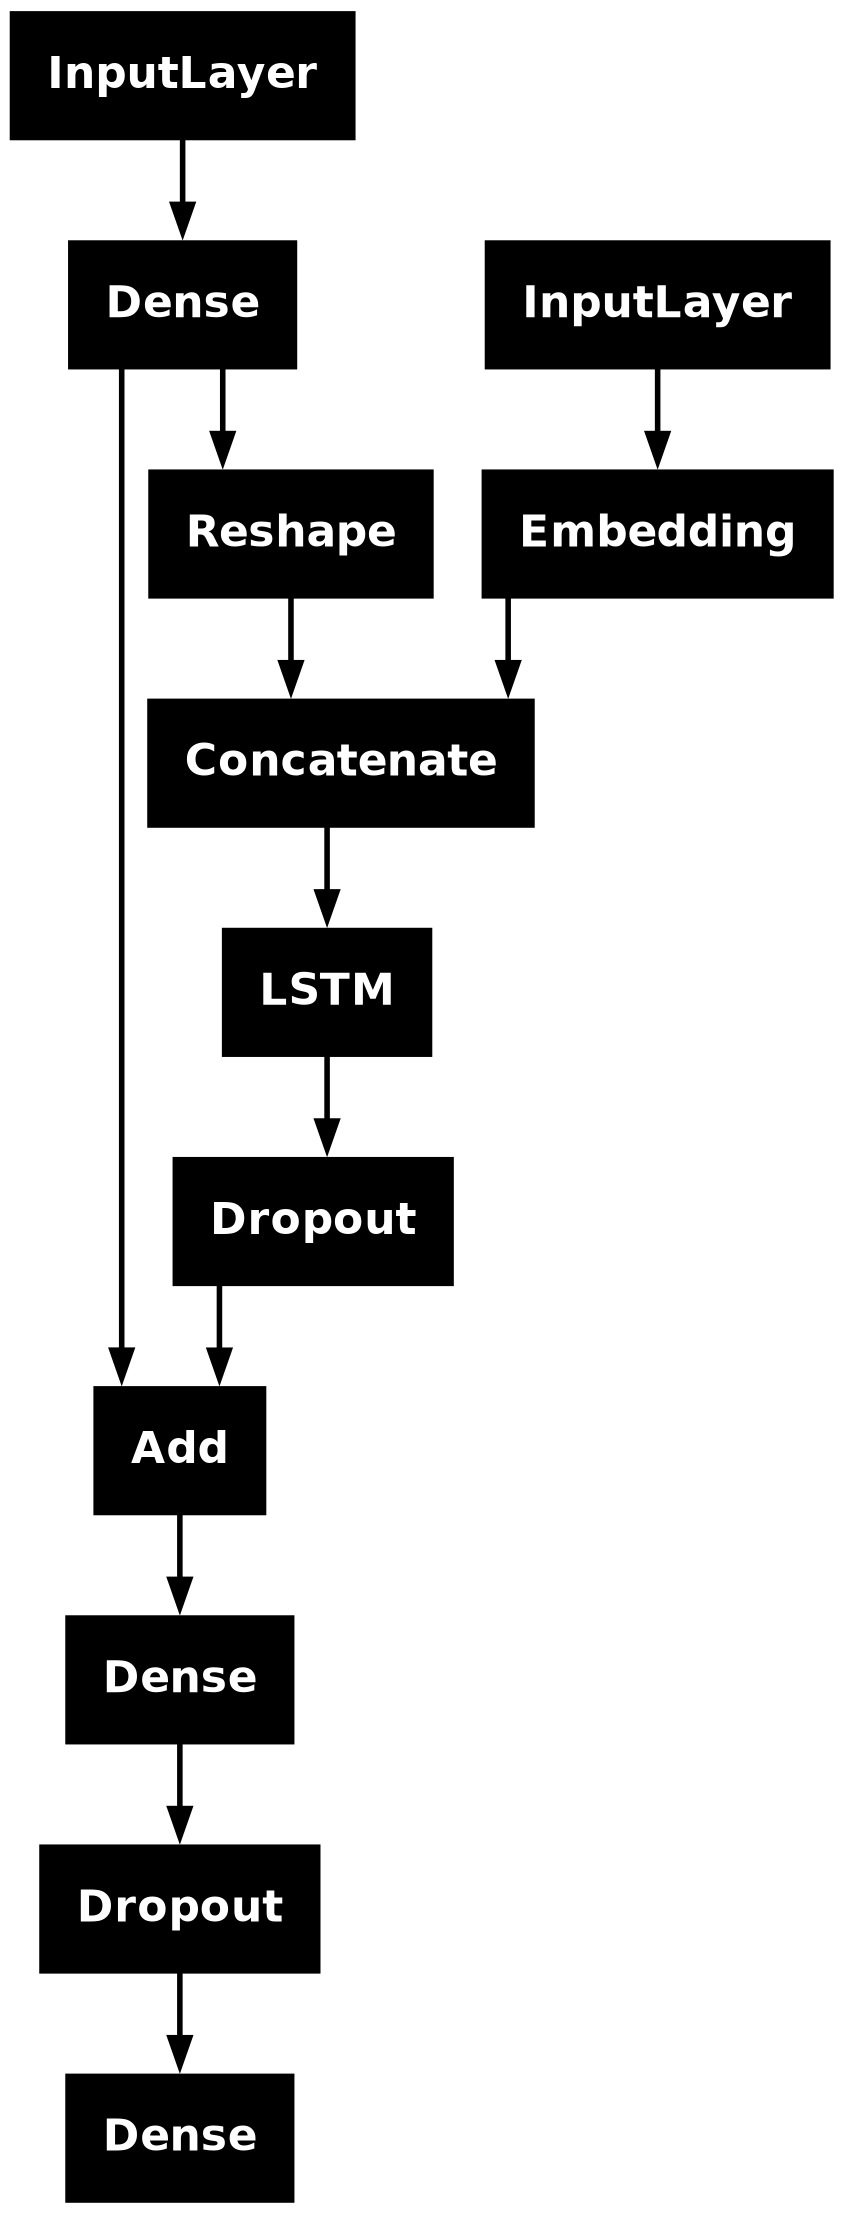

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    491,776 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 256)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 34, 256)   │  2,172,160 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 35, 256)   │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, max_length = max_length, features=features)
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, max_length = max_length, features=features)

In [36]:
model_name = "SuperAwesomeCaptioner.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

earlystopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

## Training the Model

In [37]:
history = caption_model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/30
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 5.6573
Epoch 1: val_loss improved from inf to 4.20357, saving model to SuperAwesomeCaptioner.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 314s 574ms/step - loss: 5.6562 - val_loss: 4.2036 - learning_rate: 0.0010
Epoch 2/30
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 4.2100
Epoch 2: val_loss improved from 4.20357 to 3.89559, saving model to SuperAwesomeCaptioner.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - loss: 4.2098 - val_loss: 3.8956 - learning_rate: 0.0010
Epoch 3/30
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.9355
Epoch 3: val_loss improved from 3.89559 to 3.75911, saving model to SuperAwesomeCaptioner.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - loss: 3.9354 - val_loss: 3.7591 - learning_rate: 0.0010
Epoch 4/30
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.7643
Epoch 4: val_loss improved from 3.75911 to 3.68269, saving model to SuperAwesomeCaptioner.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 143m

In [55]:
caption_model = load_model('/kaggle/input/densenet201/tensorflow2/aa/1/SuperAwesomeCaptioner.keras')

## Inference
- Learning Curve (Loss Curve)
- Assessment of generated captions (by checking relevance of caption wrt image, should add BLEU too I guess!)

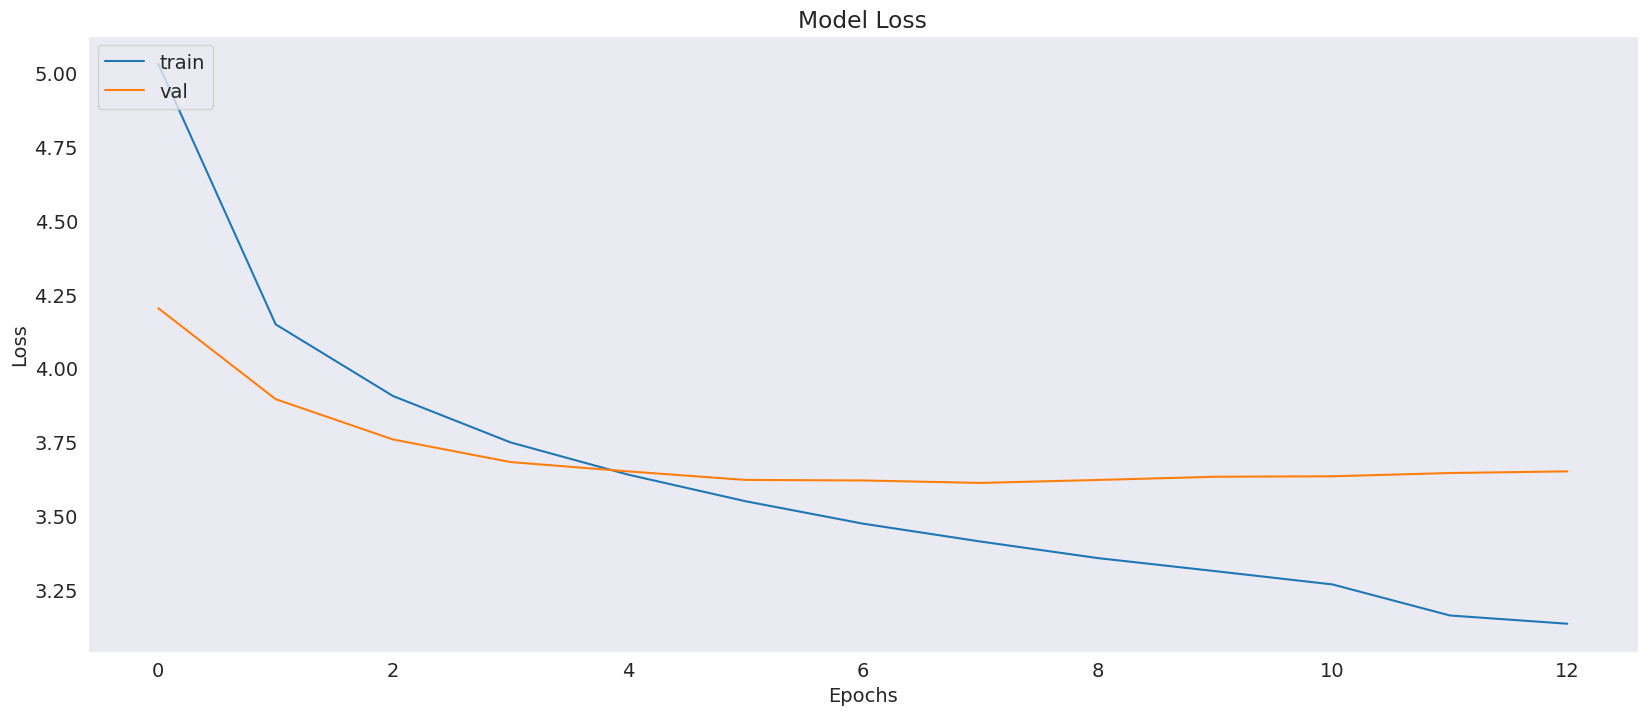

In [56]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Utility functions for Caption generation
- Utility functions to generate captions of input images at inference time.


The image embeddings are passed along the first word, followed by text embeddings of each new word used to generate the next word

In [57]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [58]:
def predictCaption(model, feature, tokenizer, max_length):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        
        y_pred = np.argmax(model.predict([feature, sequence]))
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == "endseq":
            break
            
    return in_text

## Inference

In [59]:
samples = test.sample(20)
samples.reset_index(drop=True, inplace=True)

In [60]:
for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.
    
    caption = predictCaption(caption_model, features[record['image']], tokenizer, max_length)
    caption = caption.rsplit(' ', 1)[0].split(' ', 1)[1]
    samples.loc[index, 'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

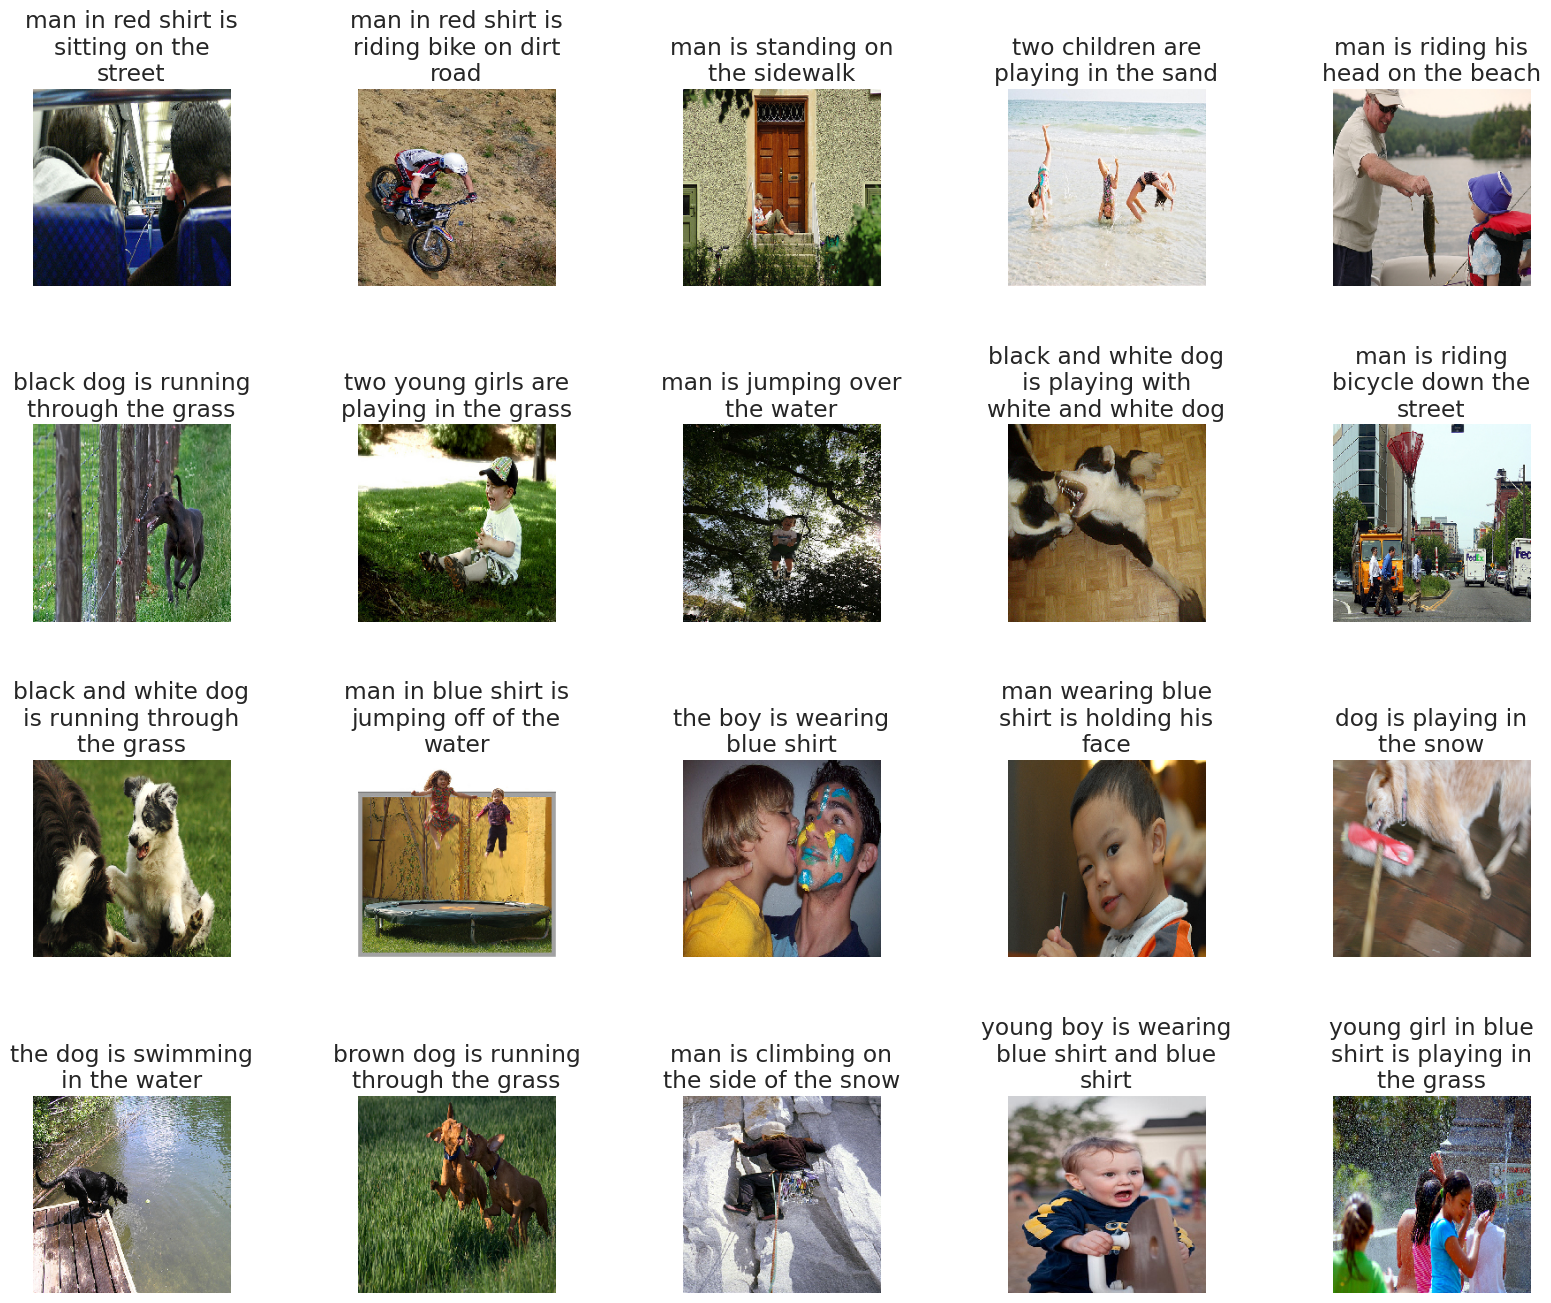

In [61]:
displayImages(samples, 20)

In [50]:
maps = captionss.set_index('image')['caption'].to_dict()

In [ ]:
"""actual, predicted = list(), list()

for key in tqdm(test['image']):
    #print(key)
    # Get actual caption
    captions = maps[key]
    y_pred = predictCaption(caption_model, features[key], tokenizer, max_length)
    
    # Split caption into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # Append to list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))"""